Imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Config

In [15]:
labeled_path = "../data/labels.parquet"

Loading Dataset

In [3]:
dataset = pd.read_parquet(labeled_path)
dataset.head()

,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


Evaluation

Generate temporary predicted Data

In [4]:
def generate_temporary_prediction(dataset):
    predicted_demand = dataset.Demand.shift(1)
    predicted_data = pd.DataFrame(dataset[['Location', 'Date']])
    predicted_data['Demand'] = predicted_demand
    return predicted_data


In [5]:
predicted_data = generate_temporary_prediction(dataset)
predicted_data = predicted_data.dropna()
predicted_data.head()

,Location,Date,Demand
1,1,2023-01-02,40.0
2,1,2023-01-03,31.0
3,1,2023-01-04,27.0
4,1,2023-01-05,7.0
5,1,2023-01-06,15.0


calculate loss functions

In [43]:
# fix_inf_val will add to numerator and denumerator to prevent having the inf value
def calculate_loss_mape(actual_data, predicted_data, fix_inf = 1):
    losses_df = actual_data[['Location','Date']].copy()
    losses_df['actual_demand'] = actual_data.Demand
    losses_df['predicted_demand'] = predicted_data.Demand
    losses_df = losses_df.dropna()

    fix_inf_val = np.where(losses_df['actual_demand']==0, fix_inf, losses_df['actual_demand'])    
    losses_df['error'] = ((np.abs(losses_df['actual_demand']-losses_df['predicted_demand']))/
                          (losses_df['actual_demand']+fix_inf_val))*100

    loss_per_location = losses_df.groupby('Location').agg({'error':'mean'})
    loss_per_date = losses_df.groupby('Date').agg({'error':'mean'})
    return loss_per_location, loss_per_date


In [44]:
loss_per_location, loss_per_date = calculate_loss_mape(dataset, predicted_data)
loss_per_location.head()

,error
Location,
1,28.647898
2,30.833333
3,68.805556
4,42.190355
5,63.888889


In [45]:
loss_per_date.head()

,error
Date,
2023-01-01,6750.540743
2023-01-02,70.710765
2023-01-03,28.132564
2023-01-04,29.580036
2023-01-05,27.390765


In [102]:
# fix_inf_val will add to numerator and denumerator to prevent having the inf value
def calculate_loss_rmse(actual_data, predicted_data):
    losses_df = actual_data[['Location','Date']].copy()
    losses_df['actual_demand'] = actual_data.Demand
    losses_df['predicted_demand'] = predicted_data.Demand
    losses_df = losses_df.dropna()

    losses_df['error'] = np.square(np.subtract(losses_df['actual_demand'],losses_df['predicted_demand']))

    loss_per_location = np.sqrt(losses_df.groupby('Location').agg({'error':'mean'}))
    loss_per_date = np.sqrt(losses_df.groupby('Date').agg({'error':'mean'}))

    return loss_per_location, loss_per_date


In [103]:
rmse_loss_per_location, rmse_loss_per_date = calculate_loss_rmse(dataset, predicted_data)
rmse_loss_per_location.head()

,error
Location,
1,7.577610
2,2.494995
3,1.970618
4,100.379322
5,20.479665


In [104]:
rmse_loss_per_date.head()

,error
Date,
2023-01-01,1001.368112
2023-01-02,199.160500
2023-01-03,268.233079
2023-01-04,138.414040
2023-01-05,87.580127


Plot accuracies function

In [124]:
def plot_acc(losses: pd.DataFrame, label, method, min_threshold, mean_threshold):
    ax = losses.plot.bar(rot=0)
    plt.xlabel(str(label))
    ylabel = 'Loss: ' + method
    plt.ylabel(ylabel)
    title = 'Model Accuracy per '+ str(label)
    plt.legend("error")
    plt.title(title)

    plt.show()


Evaluate Model function

In [125]:
def prepare_report(losses: pd.DataFrame, plot_label, method, error_limit):
    min_threshold = losses.min()['error']
    max_threshold = losses.max()['error']
    mean_threshold = losses.mean()['error']

    report_dict = {
            'best_accuracy': min_threshold,
            'best_accuracy_point': [losses['error'].idxmin()],
            'worst_accuracy': max_threshold,
            'worst_accuracy_point': [losses['error'].idxmax()],
            'mean_accuracy': mean_threshold
        }
    
    if error_limit>0 :
        losses = pd.DataFrame(np.where(losses>error_limit, error_limit, losses))
    plot_acc(losses, plot_label, method, min_threshold, mean_threshold)

    return report_dict

In [126]:
def evaluate_model(dataset, predicted_data, method, error_limit):
    if method == 'mape':
        loss_per_location, loss_per_date = calculate_loss_mape(dataset, predicted_data)
    elif method == 'rmse':
        loss_per_location, loss_per_date = calculate_loss_rmse(dataset, predicted_data)
    date_report_df = pd.DataFrame(prepare_report(loss_per_date, 'date', method, error_limit))
    loc_report_df = pd.DataFrame(prepare_report(loss_per_location, 'location', method, error_limit))
    return(date_report_df, loc_report_df)

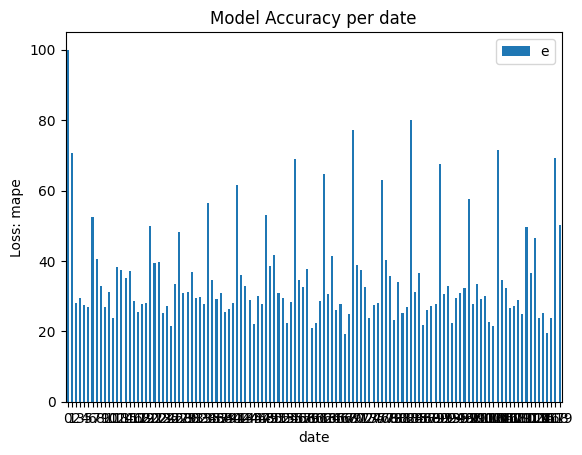

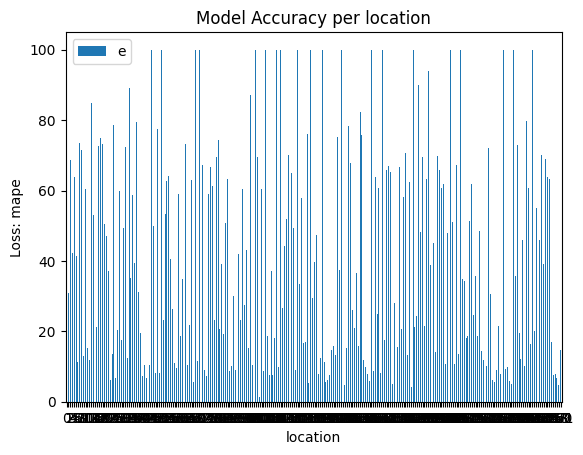

In [127]:
date_report_df, loc_report_df = evaluate_model(dataset, predicted_data, 'mape', 100)

In [99]:
print('mape per date')
date_report_df.head()

mape per date


,best_accuracy,best_accuracy_point,worst_accuracy,worst_accuracy_point,mean_accuracy
0,19.35741,2023-03-09,6750.540743,2023-01-01,90.72366


In [100]:
print("mape per location")
loc_report_df.head()

mape per location


,best_accuracy,best_accuracy_point,worst_accuracy,worst_accuracy_point,mean_accuracy
0,1.25,105,2794.583333,187,90.509859


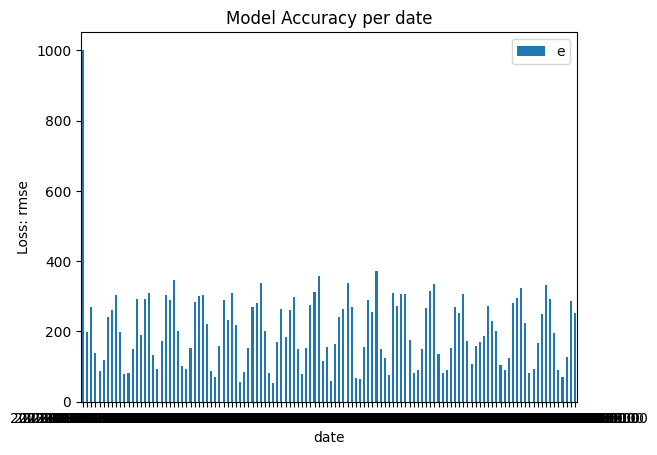

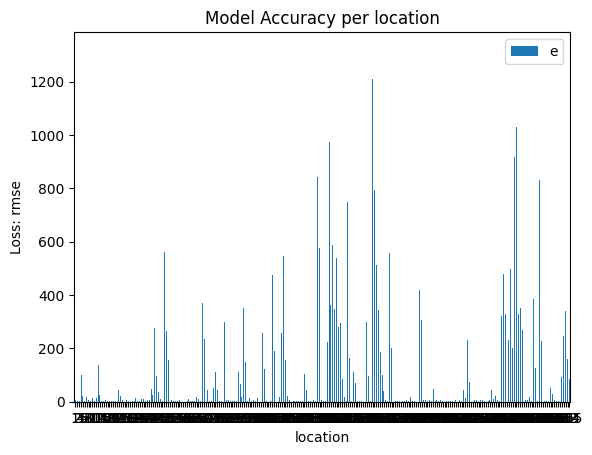

In [128]:
date_rmse_report_df, loc_rmse_report_df = evaluate_model(dataset, predicted_data, 'rmse', 0)

In [111]:
print('rmse per date')
date_rmse_report_df.head()

rmse per date


,best_accuracy,best_accuracy_point,worst_accuracy,worst_accuracy_point,mean_accuracy
0,54.575671,2023-02-16,1001.368112,2023-01-01,206.934362


In [107]:
print("rmse per location")
loc_rmse_report_df.head()

rmse per location


,best_accuracy,best_accuracy_point,worst_accuracy,worst_accuracy_point,mean_accuracy
0,0.129099,105,1319.70007,79,104.835666
